In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stat
import plotly.express as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

In [2]:
pip install keras 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [3]:
companies = pd.read_csv("sp500_companies.csv")
stocks = pd.read_csv("sp500_stocks.csv")

In [4]:
compwh= pd.read_csv("sp500_companies.csv", header= None, engine='python' )
compwh = compwh.iloc[1: , :]

c_headers=["Exchange", "Symbol", "Shortname", "Longname", "Sector", "Industry",
       "Currentprice", "Marketcap", "Ebitda", "Revenuegrowth", "City", "State",
      "Country", "Fulltimeemployees", "Longbusinesssummary", "Weight"]

compwh.columns= c_headers

In [5]:
to_drop = ['Marketcap', 'Ebitda', 'Revenuegrowth', 
           'City', 'State', 'Country', 
           'Fulltimeemployees', 'Weight', 'Currentprice', 
           'Longbusinesssummary']
compwh.drop(to_drop, inplace=True, axis=1)
compwh.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software—Infrastructure
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information
5,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail


In [6]:
stckwh = pd.read_csv("sp500_stocks.csv", header= None, engine='python')
stckwh = stckwh.iloc[1: , :]
s_headers = ['Date', 'Symbol', 'Adj_Close', 'Close', 'High', 'Low', 'Open',
       'Volume']
stckwh.columns = s_headers
stckwh = stckwh[stckwh.Date >= '2018-03-01']

In [7]:
print(compwh.describe(include="all"))

       Exchange Symbol           Shortname         Longname      Sector  \
count       502    502                 502              502         501   
unique        4    502                 498              497          11   
top         NYQ   AAPL  Under Armour, Inc.  Discovery, Inc.  Technology   
freq        352      1                   2                2          73   

                            Industry  
count                            501  
unique                           114  
top     Utilities—Regulated Electric  
freq                              20  


In [8]:
merged_data = stckwh.merge(compwh,on=["Symbol"])
merged_data.head()

,Date,Symbol,Adj_Close,Close,High,Low,Open,Volume,Exchange,Shortname,Longname,Sector,Industry
0,2018-03-01,MMM,204.9241943359375,231.33999633789062,236.8300018310547,229.52999877929688,236.14999389648438,3487100.0,NYQ,3M Company,3M Company,Industrials,Conglomerates
1,2018-03-02,MMM,204.06497192382812,230.3699951171875,231.27000427246094,226.3300018310547,229.75,2912800.0,NYQ,3M Company,3M Company,Industrials,Conglomerates
2,2018-03-05,MMM,206.22637939453125,232.80999755859375,233.7100067138672,228.52999877929688,230.0,2235300.0,NYQ,3M Company,3M Company,Industrials,Conglomerates
3,2018-03-06,MMM,206.9793243408203,233.66000366210938,235.9199981689453,230.8000030517578,234.0500030517578,2091100.0,NYQ,3M Company,3M Company,Industrials,Conglomerates
4,2018-03-07,MMM,208.6712188720703,235.57000732421875,236.22000122070312,230.58999633789062,231.22000122070312,2213800.0,NYQ,3M Company,3M Company,Industrials,Conglomerates


In [24]:
print(merged_data.dtypes)

Date         datetime64[ns]
Symbol               object
Adj_Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume              float64
Exchange             object
Shortname            object
Longname             object
Sector               object
Industry             object
dtype: object


In [10]:
merged_data["Adj_Close"] = merged_data["Adj_Close"].astype(str).astype(float)
merged_data["Volume"] = merged_data["Volume"].astype(str).astype(float)
merged_data["Close"] = merged_data["Close"].astype(str).astype(float)
merged_data["High"] = merged_data["High"].astype(str).astype(float)
merged_data["Low"] = merged_data["Low"].astype(str).astype(float)
merged_data["Open"] = merged_data["Open"].astype(str).astype(float)

In [11]:
#Changing NaN Values to O
merged_data["Adj_Close"]=merged_data["Adj_Close"].fillna(0)
#Removing NaN Values
dropvalue=merged_data[merged_data["Adj_Close"]== 0]
merged_data.drop(dropvalue.index,axis=0,inplace=True)

In [18]:
merged_data.isnull().sum()

Date         0
Symbol       0
Adj_Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Exchange     0
Shortname    0
Longname     0
Sector       0
Industry     0
dtype: int64

In [19]:
len(merged_data.index)

489319

In [14]:
merged_data = merged_data.dropna()

In [27]:
aapl = merged_data[merged_data.Symbol == 'AAPL']
aapl.head()

,Date,Symbol,Adj_Close,Close,High,Low,Open,Volume,Exchange,Shortname,Longname,Sector,Industry
43296,2018-03-01,AAPL,42.138268,43.750000,44.945000,43.165001,44.634998,195208000.0,NMS,Apple Inc.,Apple Inc.,Technology,Consumer Electronics
43297,2018-03-02,AAPL,42.429626,44.052502,44.075001,43.112499,43.200001,153816000.0,NMS,Apple Inc.,Apple Inc.,Technology,Consumer Electronics
43298,2018-03-05,AAPL,42.576511,44.205002,44.435001,43.630001,43.802502,113605600.0,NMS,Apple Inc.,Apple Inc.,Technology,Consumer Electronics
43299,2018-03-06,AAPL,42.540394,44.167500,44.562500,44.032501,44.477501,95154000.0,NMS,Apple Inc.,Apple Inc.,Technology,Consumer Electronics
43300,2018-03-07,AAPL,42.145489,43.757500,43.962502,43.567501,43.735001,126814000.0,NMS,Apple Inc.,Apple Inc.,Technology,Consumer Electronics


<AxesSubplot:>

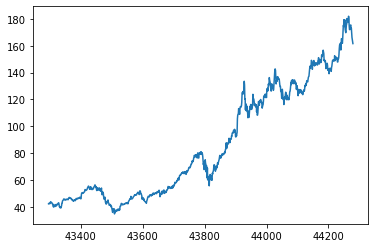

In [29]:
#Plot the True Adj Close Value
aapl['Adj_Close'].plot()

In [23]:
merged_data['Date'] = merged_data['Date'].astype('datetime64[ns]')

In [35]:
#Set Target Variable
output_var = pd.DataFrame(aapl['Adj_Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [39]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(aapl[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=aapl.index)
feature_transform.head()

,Open,High,Low,Volume
43296,0.058922,0.058119,0.053370,0.400010
43297,0.049136,0.052181,0.053004,0.292641
43298,0.053244,0.054638,0.056608,0.188336
43299,0.057848,0.055508,0.059410,0.140474
43300,0.052784,0.051413,0.056173,0.222599


In [44]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [45]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [54]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation=’relu’, return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss=’mean_squared_error’, optimizer=’adam’)
plot_model(lstm, show_shapes=True, show_layer_names=True)

SyntaxError: invalid character '’' (U+2019) (3903095430.py, line 3)